In [1]:
import numpy as np
import pandas as pd
import math
import re
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from keras import backend
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import (Dense, Dropout, Embedding, BatchNormalization, 
                                     Flatten)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from IPython.display import clear_output

import datetime
import time
import os
import sys

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# загружаем датасет и выводим первые 5 сторок
flats = pd.read_csv('/content/drive/MyDrive/UAI/Data_CSV/moscow.csv', sep=';')
flats.head()

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
1,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
3,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."


In [4]:
# Удаляем строки 'для заметок' из столбца Комнат и воccтанавливаем индексы
flats = flats[~flats['Комнат'].isin(['Для заметок:'])].reset_index(drop = True)
flats.sample(5)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
9048,1,Нижегородская м. (МЦК),2т,6/19 М,NaN,NaN,36.6/11.8/17,9001843.0,NaN,NaN,25.07.2019,6.0,AVITO.ru,Редкий продукт на рынке недвижимости от застро...
52858,1,Кропоткинская м.,3п,8/8 К,Б,С,50/28/10,27900000.0,NaN,NaN,29.06.2019,434.0,Яндекс,Вашему вниманию предлагается квартира - студия...
11703,1,Новогиреево м.,15т,3/12 П,Л,Р,39/19/8.5,5990000.0,NaN,NaN,23.07.2019,10.0,Яндекс,Продается однокомнатная квартира на 3 этаже 12...
15040,1,Бульвар Рокоссовского м.,3п,5/5 П,Б,NaN,30/?/10,6800000.0,NaN,NaN,25.07.2019,16.0,cian.ru,смотрите фотографии! Отличная квартира! Со све...
121976,Ст,Столбово м.,10т,5/7 М,NaN,NaN,29/?/?,3700000.0,NaN,NaN,19.07.2019,132.0,Яндекс,Продается 1 к кв -студия на 5 этаже 7 этажного...


In [5]:
# Выводим названия колонок
flats.columns.tolist()

['Комнат',
 'Метро / ЖД станции',
 'От станции',
 'Дом',
 'Балкон',
 'Санузел',
 'Площадь',
 'Цена, руб.',
 'ГРМ',
 'Бонус агенту',
 'Дата',
 'Кол-во дней в экспозиции',
 'Источник',
 'Примечание']

In [6]:
# Удаляем колонки которые не будут использоваться при создания Нейронной Сети
flats.drop(['ГРМ', 'Бонус агенту', 'Дата', 'Кол-во дней в экспозиции', 'Источник', 'Примечание'], axis=1, inplace=True)
flats.head(3)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб."
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0
1,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0
2,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0


In [7]:
flat = 17 
for i in range(len(flats.values[flat])): 
  print(i, flats.columns[i], ':', flats.values[flat][i])

0 Комнат : 1
1 Метро / ЖД станции : Красногвардейская м.
2 От станции : 3п
3 Дом : 2/30 М
4 Балкон : -
5 Санузел : С
6 Площадь : 41.2/13.8/18.9
7 Цена, руб. : 7230600.0


In [8]:
# данные из датасета в массив numpy
data = flats.values

In [9]:
# Пример одного объявления из массива
data[17]

array(['1', 'Красногвардейская м.', '3п', '2/30 М', '-', 'С',
       '41.2/13.8/18.9', 7230600.0], dtype=object)

Готовим данные для Нейронной сети без Примечания

f - квартира

In [10]:
# Выводим уникальные значения в столбце комнат
flats.Комнат.unique()

array(['1', nan, '2', '5', '6', '7', '8', '10', '9', '14', '13', '11',
       '15', '16', '12', '20', '30', '01.мар', '02.апр', '01.апр',
       '01.янв', '03.май', '01.фев', '02.мар', '01.июн', '01.авг',
       '03.апр', '01.май', '02.май', '01.сен', '01.июл', '02.июл',
       '03.июн', '05.июн', '03.авг', '01.окт', '04.май', '02.июн',
       '04.июн', '01.дек', '4', '03.июл', '02.фев', '03.мар', 'Ст'],
      dtype=object)

In [11]:
# Количество комнат
def get_rooms_count(f, max_rooms):
    rooms_str = f[0] # сторока с числом комнат

    rooms_count = 0
# создаем блок try-exept для предотвращения сбоя в работе при ошибке
    try:
        rooms_count = int(rooms_str)
        if rooms_count > max_rooms:
            rooms_count == max_rooms
    except:
        if rooms_str == rooms_str:
            if 'Ст' in rooms_str:
                rooms_count = max_rooms + 1

    return rooms_count

# Переводим количество комнат в категорию
def  get_rooms_count_to_categorical(f, max_rooms):
    rooms_count = get_rooms_count(f, max_rooms)
    rooms_count = utils.to_categorical(rooms_count, max_rooms + 2)

    return rooms_count

In [12]:
# Выводим уникальные значения в столбце Метро / ЖД станции
flats['Метро / ЖД станции'].unique()

array(['Шелепиха м.', 'Пятницкое шоссе м.', 'Планерная м.',
       'Шаболовская м.', 'Бабушкинская м.', 'Улица Дмитриевского м.',
       'Бульвар Рокоссовского м.', 'Марьина Роща м.', 'Марьино м.',
       'Печатники м.', 'Красногвардейская м.', 'Площадь Ильича м.',
       'Славянский бульвар м.', 'Раменки м.', 'Ботанический сад м.',
       'Маяковская м.', 'Хорошево м. (МЦК)', 'Проспект Вернадского м.',
       'Серпуховская м.', 'Улица Академика Янгеля м.', 'Крылатское м.',
       'Первомайская м.', 'Измайловская м.', 'Мичуринский проспект м.',
       'Бульвар Дмитрия Донского м.', 'Коптево м. (МЦК)',
       'Ростокино м. (МЦК)', 'Саларьево м.', 'Октябрьское поле м.',
       'Фрунзенская м.', 'Спортивная м.', 'Царицыно м.', 'Арбатская м.',
       'Юго-Западная м.', 'Белокаменная м. (МЦК)', 'Молодежная м.',
       'Медведково м.', 'Кунцевская м.', 'Авиамоторная м.',
       'Тимирязевская м.', 'Столбово м.', 'Селигерская м.', 'Коньково м.',
       'Бунинская аллея м.', 'Теплый стан м.',


In [13]:
# Наличие станция Метро и расстояние до неё
# станция метро
all_stations = ['Площадь Революции', 'Арбатская', 'Смоленская', 'Красные Ворота', 
            'Чистые Пруды', 'Лубянка', 'Охотный Ряд', 'Библиотека им. Ленина', 
            'Кропоткинская', 'Сухаревская', 'Тургеневская', 'Китай-Город', 
            'Третьяковская', 'Трубная', 'Сретенский Бульвар', 'Цветной Бульвар',
            'Чеховская', 'Боровицкая', 'Полянка', 'Маяковская', 'Тверская', 
            'Театральная', 'Новокузнецкая', 'Пушкинская', 'Кузнецкий Мост', 
            'Александровский Сад', 'Киевская', 'Парк Культуры', 'Октябрьская', 
            'Добрынинская', 'Павелецкая', 'Таганская', 'Курская', 'Комсомольская', 
            'Проспект Мира', 'Новослободская', 'Белорусская', 'Краснопресненская', 
            'Бауманская', 'Электрозаводская', 'Семёновская', 'Площадь Ильича', 
            'Авиамоторная', 'Шоссе Энтузиастов', 'Рижская', 'Крестьянская Застава', 
            'Дубровка', 'Пролетарская', 'Волгоградский Проспект', 'Текстильщики', 
            'Автозаводская', 'Технопарк', 'Коломенская', 'Тульская', 'Нагатинская', 
            'Нагорная', 'Шаболовская', 'Ленинский Проспект', 'Академическая', 
            'Фрунзенская', 'Спортивная', 'Воробьёвы Горы', 'Студенческая', 
            'Кутузовская', 'Фили', 'Парк Победы', 'Выставочная', 'Международная', 
            'Улица 1905 года', 'Беговая', 'Полежаевская', 'Динамо', 'Аэропорт', 
            'Сокол', 'Деловой Центр', 'Шелепиха', 'Хорошёвская', 'ЦСКА', 'Петровский Парк', 
            'Савёловская', 'Дмитровская', 'Тимирязевская', 'Достоевская', 'Марьина Роща', 
            'Бутырская', 'Фонвизинская', 'Римская', 'Алексеевская', 'ВДНХ', 
            'Красносельская', 'Сокольники', 'Преображенская Площадь', 'Партизанская', 
            'Измайловская', 'Первомайская', 'Щёлковская', 'Новокосино', 'Новогиреево', 
            'Перово', 'Кузьминки', 'Рязанский проспект', 'Выхино', 'Лермонтовский Проспект', 
            'Жулебино', 'Партизанская', 'Измайловская', 'Первомайская', 'Щёлковская', 
            'Новокосино', 'Новогиреево', 'Перово', 'Кузьминки', 'Улица Дмитриевского', 
            'Кожуховская', 'Печатники', 'Волжская', 'Люблино', 'Братиславская', 
            'Коломенская', 'Каширская', 'Кантемировская', 'Царицыно', 'Орехово', 
            'Севастопольская', 'Чертановская', 'Южная', 'Пражская', 'Варшавская', 
            'Профсоюзная', 'Новые Черёмушки', 'Калужская', 'Беляево', 'Коньково', 
            'Университет', 'Багратионовская', 'Филёвский Парк', 'Пионерская', 'Кунцевская', 
            'Молодёжная', 'Октябрьское Поле', 'Щукинская', 'Спартак', 'Тушинская', 
            'Сходненская', 'Войковская', 'Водный Стадион', 'Речной Вокзал', 
            'Беломорская', 'Ховрино', 'Петровско-Разумовская', 'Владыкино', 'Отрадное', 
            'Бибирево', 'Алтуфьево', 'Фонвизинская', 'Окружная', 'Верхние Лихоборы', 
            'Селигерская', 'Ботанический Сад', 'Свиблово', 'Бабушкинская', 'Медведково', 
            'Преображенская Площадь', 'Черкизовская', 'Бульвар Рокоссовского']

def get_metro(f, metro_stations):
    metro_str = f[1]
    metro = 0
    # Присваиваем индекс + 1, найденным станциям метро. 0-нет станции. 
    if metro_str in metro_stations:
        metro = metro_stations.index(metro_str) + 1
 
    return metro

# Создаем типы метро в зависимости от количества станций от кольца
def get_metro_type(f):
    metro_type_str = f[1]
    metro_type_classes = 5 # количество классов
    metro_type = metro_type_classes - 1
    
    # Распределяем по станциям
    metro_stations_inside_circle = all_stations[:26]
    metro_stations_one_circle = all_stations[26:38]
    metro_stations_two_circle = all_stations[38:92]
    metro_stations_three_circle = all_stations[92:]
    
    # распределяем по категориям
    if metro_type_str in metro_stations_inside_circle:
        metro_type = 0
    if metro_type_str in metro_stations_one_circle:
        metro_type = 1
    if metro_type_str in metro_stations_two_circle:
        metro_type = 2
    if metro_type_str in metro_stations_three_circle:
        metro_type = 3

    # В категорию
    metro_type = utils.to_categorical(metro_type, metro_type_classes)

    return metro_type

In [14]:
# Выводим уникальные значения в столбце От станции
flats['От станции'].unique()

array(['12п', '30т', '5т', '15п', '2п', '10п', '20п', '3п', '8п', '20т',
       '7п', '10т', '7т', nan, '13п', '25п', '5п', '28т', '21п', '15т',
       '6п', '18п', '16п', '35т', '14п', '4п', '17п', '6т', '23п', '11п',
       '36п', '32т', '29т', '27т', '19п', '3т', '8т', '1п', '9п', '12т',
       '25т', '18т', '4т', '13т', '26п', '33т', '24т', '24п', '2т', '11т',
       '14т', '23т', '9т', '22п', '45т', '30п', '29п', '27п', '38т',
       '21т', '19т', '50т', '73т', '28п', '16т', '40т', '17т', '26т',
       '60т', '34т', '71п', '22т', '55т', '52т', '31т', '54т', '44т',
       '43т', '37т', '57т', '49т', '58т', '51т', '56т', '59т', '46т',
       '39т', '41т', '48т', '64т', '53т', '1т', '54п', '47т', '34п',
       '75т', '93т', '42т', '36т', '77т', '65т', '58п', '70т', '74т',
       '79т', '66т', '31п', '32п', '80т', '61т', '940п', '120т'],
      dtype=object)

In [15]:
# Расстояние до метро
def get_metro_distance(f):
    metro_distance_str = f[2]
    
    metro_distance = 0
    distance_type = 0

    if metro_distance_str == metro_distance_str:
        if len(metro_distance_str) > 0:
            if metro_distance_str[-1] =='п': 
                distance_type = 1                # пешком
            elif metro_distance_str[-1] == 'т':
                distance_type = 2                # транспортом

            # Выбираем толоко числа
            metro_distance_str[:-1]
    # создаем блок try-exept для предотвращения сбоя в работе при ошибке
            try:
    # разделяем дистаеции по категориям
                metro_distance = int(metro_distance_str)
                if metro_distance < 3:
                    metro_distance = 1
                if metro_distance < 6:
                    metro_distance = 2
                if metro_distance < 9:
                    metro_distance = 3
                if metro_distance < 12:
                    metro_distance = 4
                if metro_distance < 15:
                    metro_distance = 5
                if metro_distance < 20:
                    metro_distance = 6
                else: metro_distance = 7
            except:
                metro_distance = 0

    metro_distance_classes = 8

    # Преобразовываем индексы расстояний(тип_дистанции * дистанцию)
    if distance_type == 1:
        metro_distance = metro_distance                # пешком
    elif distance_type ==2:
        metro_distance += metro_distance_classes       # транспортом
    elif distance_type == 0:
        metro_distance += 2 * metro_distance_classes   # неизвестный тип

    # В категорию
    metro_distance = utils.to_categorical(metro_distance, metro_distance_classes * 3)

    return metro_distance

In [16]:
# Выводим уникальные значения в столбце Дом
flats.Дом.unique()

array(['35/37 М', '11/14 П', '11/22 П', ..., '54/65 М', '3/53 М-К',
       '52/73 П'], dtype=object)

In [17]:
# Дом. Этаж.
def get_hose_type_and_floor(f):
    try:
        house_str = f[3]
    except:
        hosuse_str = ''

    house_type = 0       # тип дома
    floor_flat = 0       # этаж квартиры
    floors_house = 0     # этажность дома
    is_last_floor = 0    # последний этаж

    if house_str == house_str:
        if len(house_str) > 1:
            try:
                slash_index = house_str.index('/')   # ищем разделитель
            except:
                print(house_str)
            try:
                space_index = house_str.index(' ')   # ищем разделитель
            except:
                print(house_str)

            # выбтаскиваем строки
            floor_flat_str = house_str[:slash_index]                   # этаж
            floors_house_str = house_str[slash_index +1:space_index]   # этажность дома
            house_type_str = house_str[space_index +1:]                # тип дома

            # Категории этажа
            try:
                floor_flat = int(floor_flat_str)
                floor_flat_save = floor_flat
                
                if floor_flat__save == 1:
                    floor_flat = 1
                if floor_flat_save < 5:
                    floor_flat = 2
                if floor_flat_save < 10:
                    floor_flat = 3
                if floor_flat_save < 20:
                    floor_flat = 4
                if floor_flat_save >= 20:
                    floor_flat = 5
                
                if floor_flat == floors_house:
                    is_last_floor = 1
            except:
                floor_flat = 0

            # Этажность дома
            try:
                floors_house = int(floors_house_str)
                floors_house_save = floors_house
                if floors_house_save < 5:
                    floors_house = 1
                if floors_house_save < 10:
                    floors_house = 2
                if floors_house_save < 20:
                    floors_house = 3
                if floors_house_save >= 20:
                    floors_house = 4
            except:
                floors_house = 0

            # Тип дома
            if len(house_type_str) > 0:
                if 'М' in house_type_str:
                    house_type = 1
                if 'К' in house_type_str:
                    house_type = 2
                if 'П' in house_type_str:
                    house_type = 3
                if 'Б' in house_type_str:
                    house_type = 4
                if '?' in house_type_str:
                    house_type = 5
                if '-' in house_type_str:
                    house_type = 6

        # Переводим все по этажам и дому в categorical
        floor_flat = utils.to_categorical(floor_flat, 6)
        floors_house = utils.to_categorical(floors_house, 5)
        house_type = utils.to_categorical(house_type, 7)

    return floor_flat, floors_house, is_last_floor, house_type

In [18]:
# Выводим уникальные значения в столбце Балкон
flats.Балкон.unique()

array([nan, 'Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л',
       'ЭркЛ', '3Л', '4Л', '*Л', '*Б'], dtype=object)

In [19]:
# Тип балкона
def get_balcony(f):
    balcony_str = f[4]
    # все варианты балконов в датасете
    balcony_variants =  ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
    # Проверяем на Nan выделяем 0 для Nan
    if balcony_str == balcony_str:
        balcony = balcony_variants.index(balcony_str) + 1
    else:
        balcony = 0

    # В categorical
    balcony = utils.to_categorical(balcony, 16)

    return balcony

In [20]:
# Выводим уникальные значения в столбце Санузел
flats.Санузел.unique()

array(['2', 'Р', 'С', nan, '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4',
       '3', '3Р'], dtype=object)

In [21]:
# Тип санузла
def get_wc(f):
    wc_str = f[5]
    wc_variants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']

    if wc_str == wc_str:
        wc = wc_variants.index(wc_str) + 1
    else:
         wc = 0

    # В categorical
    wc = utils.to_categorical(wc, 14)

    return wc

In [22]:
# Выводим уникальные значения в столбце Площадь
flats.Площадь.unique()

array(['64.1/23/20', '38.4/17/9', '38.2/19.9/9.9', ..., '17.9/15.3/?',
       '26/10.9/?', '26/10.9/7'], dtype=object)

In [23]:
# Площадь квартиры
def get_area(f):
    area_str = f[6]
    
    if ('/' in area_str):
        slash_index = area_str.index('/')
        try:
            area = float(area_str[:slash_index])
        except:
            area = 0   # не получается возврат 0
    else:
            area = 0   # нет разделителя возврат 0
    
    return area

In [24]:
# Цена
def get_price(f):
    price_str = f[7]

    try:
        price = float(price_str)
    except:
        price = 0

    return price

In [25]:
# Объединяем все числовые параметры
def get_numbers_parameters(f, metro_stations):
    # загружаем все по отдельности
    rooms_count_type = get_rooms_count_to_categorical(f, 30)
    metro = get_metro(f, metro_stations)
    metro_type = get_metro_type(f)
    metro_distance = get_metro_distance(f)
    floor_flat, floors_house, is_last_floor, house_type = get_hose_type_and_floor(f)
    balcony = get_balcony(f)
    wc = get_wc(f)
    area = get_area(f)

    # Объединяем в один лист
    out = list(rooms_count_type)
    out.append(metro)
    out.extend(metro_type)
    out.extend(metro_distance)
    out.extend(floor_flat)
    out.extend(floors_house)
    out.append(is_last_floor)
    out.extend(balcony)
    out.extend(wc)
    out.append(area)

    return out

In [26]:
# Генерируем обучающую выборку X_train
def get_X_train(data):
    metro_stations = list(flats['Метро / ЖД станции'].unique()) #строка со всеми уникальными вариантами
    # Превращаем в векторы параметров и записываем в X_train
    X_train = [get_numbers_parameters(f, metro_stations) for f in data]
    X_train = np.array(X_train)

    return X_train

In [27]:
# Генерируем обучающую выборку y_train
def get_y_train(data):
    # Загружаем все цены нв квартиры
    price_list = [get_price(f) for f in data]
    y_train = np.array(price_list)

    return y_train

In [28]:
# Формируем обучающую выборку
X_train = get_X_train(data)
y_train = get_y_train(data)

In [29]:
X_train.shape, y_train.shape

((126268, 105), (126268,))

In [30]:
# Пример
print(X_train[1])
print(y_train[1])

[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   2.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
  0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  38.4]
4800000.0


In [31]:
# Стандартизируем данные
X_scaler = StandardScaler()
# пердаем двумерный вектор
X_scaler.fit(X_train.reshape(-1, 1))   
# нормализация по нормальному распределению
X_train_scaled = X_scaler.transform(X_train.reshape(-1, 1)).flatten()  

# Пример
print(X_train_scaled.shape)
print(X_train[5])
print(X_train_scaled[5])

(13258140,)
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 44.]
-0.10621547823476808


In [32]:
# Нормируем выходные даные - Цену
y_scaler = StandardScaler()
y_scaler.fit(y_train.reshape(-1, 1))
y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1))

print(y_train_scaled.shape)
print(y_train[5])
print(y_train_scaled[5])

(126268, 1)
12700000.0
[-0.153471]


In [33]:
# максимальные и минимальные значения после нормализации
print(f'Минимальное: {min(X_train_scaled)} \nМаксимальное: {max(X_train_scaled)}')

Минимальное: -0.10621547823476808 
Максимальное: 172.18674774400884


In [34]:
# Нейронка на числовых данных
model = Sequential([
                    #BatchNormalization(input_shape=(X_train.shape[1],)),
                    Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
                    Dense(16, activation='relu'), #'tanh'
                    Dense(8, activation='relu'),
                    #Dense(128, activation='relu'),
                    Dense(1, activation='linear')
                    ])

In [35]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

Создаем Custom Callbacks

In [36]:
class MyTimeCallback(keras.callbacks.Callback):
    
    def __init__(self):
        super().__init__()

        clear_output(wait=2) 
              
    def on_epoch_begin(self, epoch, logs={}):

        clear_output(wait=2)
        
        self.start_datetime = datetime.datetime.now()
        self.epoch_time_start = time.time()  
    
    def on_epoch_end(self, epoch, logs=None):
    
        current_datetime = datetime.datetime.now()
        
        diff = current_datetime - self.start_datetime
        avg_time_per_epoch = (diff / (epoch + 1))
        left_epochs = (self.params['epochs'] - (epoch + 1))
        left = avg_time_per_epoch * left_epochs
        print(f'Старт: {self.start_datetime.strftime("%d-%m-%Y  %H:%M:%S")}  ', 
              f'Текущее время: {current_datetime.strftime("%d-%m-%Y  %H:%M:%S")}  ', 
              f'Прошедшее время: {diff.total_seconds():.2f}  ', 
              f'Оставшееся время: {left.total_seconds():.2f}  ',
              f'Суммарное время: {(time.time() - self.epoch_time_start):.2f}')


class MyPersonalCallbacs(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    

    def on_epoch_begin(self, epoch, logs=None):

        if self.model is None:
            return
        History = self.model.history.history
        
        if epoch > 0:
            plt.figure()
            plt.plot(History['mae'], label=('Средняя максимальная ошибка на обучающей выборке'))
            plt.plot(History['val_mae'], label='Средняя максимальная ошибка на проверочной выборке выборке')
            plt.xlabel('Эпоха обучения')
            plt.ylabel('Средняя абсолютная ошибка')
            plt.legend()
            plt.grid()
            plt.show()

        if self.model is None:
            return
        
        if epoch > 0:
            price = y_train[63134:]
            pred = model.predict(X_train[63134:]) 

            fig = plt.figure()
            groups= ('price', 'prediction')
            colors = np.random.rand(63134, 3)
            ax = fig.add_subplot(1, 1, 1,) 
            ax.scatter(price, pred, alpha=0.8, c=colors, edgecolors='none', s=30)
            plt.title('Цены и предсказанные цены', fontsize=16)
            plt.xlabel('Правильные значение', fontsize=12)
            plt.ylabel('Предсказания', fontsize=12)

            plt.show()

  
    
    # Вывод средней максимальной ошибки в конце каждой эпохи
    def on_epoch_end(self, epoch, logs=None):
        print(f'Эпоха № {epoch+1}. Средняя максимальная ошибка на обучающей выборке: {logs["mae"]:.5f}\
        ||       Средняя максимальная ошибка на проверочной выборке выборке: {logs["val_mae"]:.5f}')

                
    # learning rate
class LossCallback(keras.callbacks.Callback):
    def __init__(self):
        super(LossCallback, self).__init__()
        self.model = model
     
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 0:   
            lr = float(backend.get_value(self.model.optimizer.lr))
            backend.set_value(self.model.optimizer.lr, lr)

            if logs['val_mae'][-10].std() > 0.25:
                #model.optimizer.lr = optimizer.lr.set_value(optimizer.lr * 1.5)
                #lr.set_value(self.model.optimizer.lr, lr*1.5)
                model.optimizer.lr = lr.set_value(lr * 1.5)

            elif history.history['val_mae'][-10].std() < 0.05:
                model.optimizer.lr = lr.set_value(optimizer.lr * 0.85)
            
            return get_value(model.optimizer.lr)

 
    #Выводим скорость обучения в конце эпохи
    def on_epoch_end(self, epoch, logs=None):
        lr = float(backend.get_value(self.model.optimizer.lr))
        print(f'learing_rate= {lr:.5f}')
        

    # Сохранение лучшего результата и вывод mae в конце эпохи
class SaveCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        ModelCheckpoint('/content/drive/MyDrive/UAI/Data_CSV/flats.hdf5', monitor='val_mae', save_best_only=True)


In [37]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.0001)


In [38]:
history = model.fit(X_train, y_train_scaled, epochs=20, batch_size=32, validation_split=0.2, callbacks=[MyPersonalCallbacs(), LossCallback(), MyTimeCallback(), SaveCallback()], verbose=0)

Эпоха № 20. Средняя максимальная ошибка на обучающей выборке: 0.04812        ||       Средняя максимальная ошибка на проверочной выборке выборке: 0.53225
learing_rate= 0.00100
Старт: 10-09-2021  17:43:27   Текущее время: 10-09-2021  17:43:36   Прошедшее время: 8.99   Оставшееся время: 0.00   Суммарное время: 8.99


In [39]:
mse, mae = model.evaluate(X_train[63134:], y_train[63134:])
print(mse,'//', mae)

1973/1973 [==============================] - 5s 3ms/step - loss: 13231488568918016.0000 - mae: 40359772.0000
1.3231488568918016e+16 // 40359772.0


In [40]:
# максимальная точность  и ошибка на обучающей и проверочной выборе
print(f'Минимальная MAE на обучающей выборке: {min(history.history["mae"])} \
\nМинимальная MSE на обучающей выборе: {min(history.history["loss"])} \
\nМинимальная MAE на проверочной выборке: {min(history.history["val_mae"])} \
\nМинимальная MSE на проверочной выборе: {min(history.history["val_loss"])}')

Минимальная MAE на обучающей выборке: 0.04811501502990723 
Минимальная MSE на обучающей выборе: 0.02243407443165779 
Минимальная MAE на проверочной выборке: 0.5048865675926208 
Минимальная MSE на проверочной выборе: 1.5695003271102905


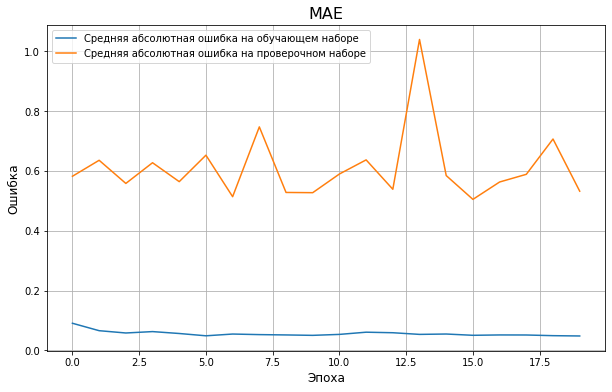

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Ошибка',fontsize=12)
plt.legend()
plt.grid()
plt.title('MAE', fontsize=16)

plt.show()

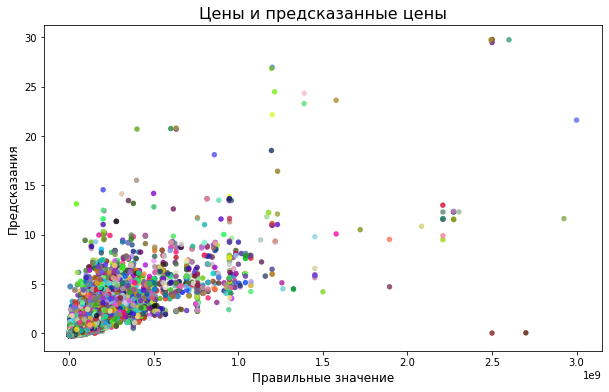

In [42]:
price = y_train[63134:]
pred = model.predict(X_train[63134:]) 

fig = plt.figure(figsize=(10, 6))
groups= ('price', 'prediction')
colors = np.random.rand(63134, 3)
ax = fig.add_subplot(1, 1, 1,) 
ax.scatter(price, pred, alpha=0.8, c=colors, edgecolors='none', s=30)
plt.title('Цены и предсказанные цены', fontsize=16)
plt.xlabel('Правильные значение', fontsize=12)
plt.ylabel('Предсказания', fontsize=12)

plt.show()

In [43]:
# Средняя ошибка
prediction = model.predict(X_train) 

prediction_unscaled = y_scaler.inverse_transform(prediction).flatten()

delta = prediction_unscaled - y_train
abs_delta = abs(delta)
mean_price_flats = (sum(abs_delta) / (0xf4240 * len(abs_delta)))
print('Средняя ошибка Цены: ', '%.4f' % mean_price_flats)

Средняя ошибка Цены:  11.3559
